<h1 style="text-align: center; font-weight: bold;">
Model LSTM for Time Series Forecasting Temperature
</h1>


# LLibreries

In [1]:
# 📦 Gestió bàsica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# 📊 Tractament i visualització de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuració visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# 📈 Barra de progrés
from tqdm.notebook import tqdm

# 🧪 Preprocessament i mètriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# 🤖 TensorFlow i Keras — Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model



2025-06-12 08:51:46.084633: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 08:51:46.107422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importació de Dades

## Importació i reformateig des de JSON 

No cal fer-ho es pot llegir directament des del CSV ja preprocessat


La següent cel·la és per llegir des del CSV

In [ ]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

# Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

# Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

# Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'], utc=True)

df = df.sort_values(by='data')

# Eliminem les dades que estan entre hores, es a dir en minuts que no son 0
df = df[df['data'].dt.minute == 0]

# Restablir l'index
df = df.reset_index(drop=True)

df

## Importació de dades dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [2]:
#Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades_csv = 'SCM_T_Z1.csv'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)

# Llegir el fitxer CSV i importar les dades

df = pd.read_csv(path_dades)

# Convertir la columna 'data' a tipus datetime
df['data'] = pd.to_datetime(df['data'], utc=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


In [3]:
# seleccionem les dades LSTM, del 2020 en endavant ja que a partir d'aleshores no tenen cap interrupció
df_lstm = df[df['data'] >= '2020-01-01'].copy()

# Restablir l'index
df_lstm = df_lstm.reset_index(drop=True)

df_lstm

,data,valor
0,2020-01-01 00:00:00+00:00,1.30
1,2020-01-01 01:00:00+00:00,1.60
2,2020-01-01 02:00:00+00:00,3.20
3,2020-01-01 03:00:00+00:00,4.40
4,2020-01-01 04:00:00+00:00,4.00
...,...,...
43843,2024-12-31 19:00:00+00:00,0.10
43844,2024-12-31 20:00:00+00:00,-0.60
43845,2024-12-31 21:00:00+00:00,-0.60
43846,2024-12-31 22:00:00+00:00,-0.70


## Visualització Prèvia de les dades

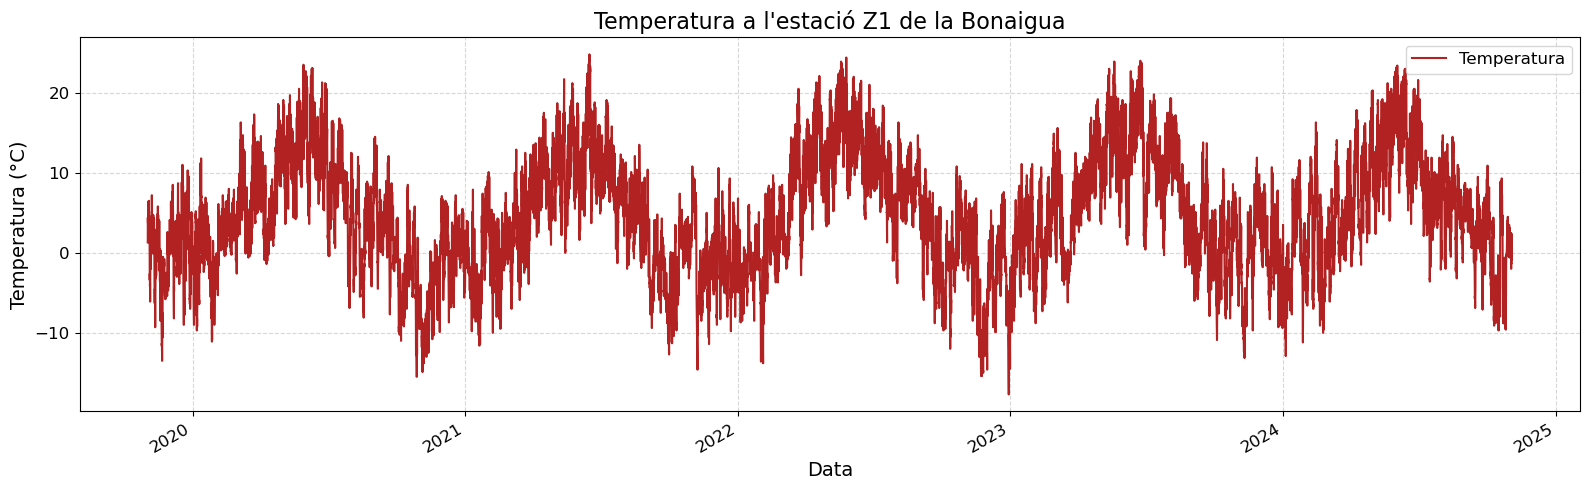

In [4]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Separació de les dades en entrenament, validació i test

In [5]:
# Definim les dates límit per la separació
data_max = df_lstm['data'].max()

data_limit_train = data_max - pd.DateOffset(months=6)      # Límit final del train
data_limit_val = data_max - pd.DateOffset(months=3)        # Límit final de la validació

# Separem els datasets
df_train = df_lstm[df_lstm['data'] <= data_limit_train].copy().reset_index(drop=True)
df_val = df_lstm[(df_lstm['data'] > data_limit_train) & (df_lstm['data'] <= data_limit_val)].copy().reset_index(drop=True)
df_test = df_lstm[df_lstm['data'] > data_limit_val].copy().reset_index(drop=True)


## Visualització dels conjunts de dades

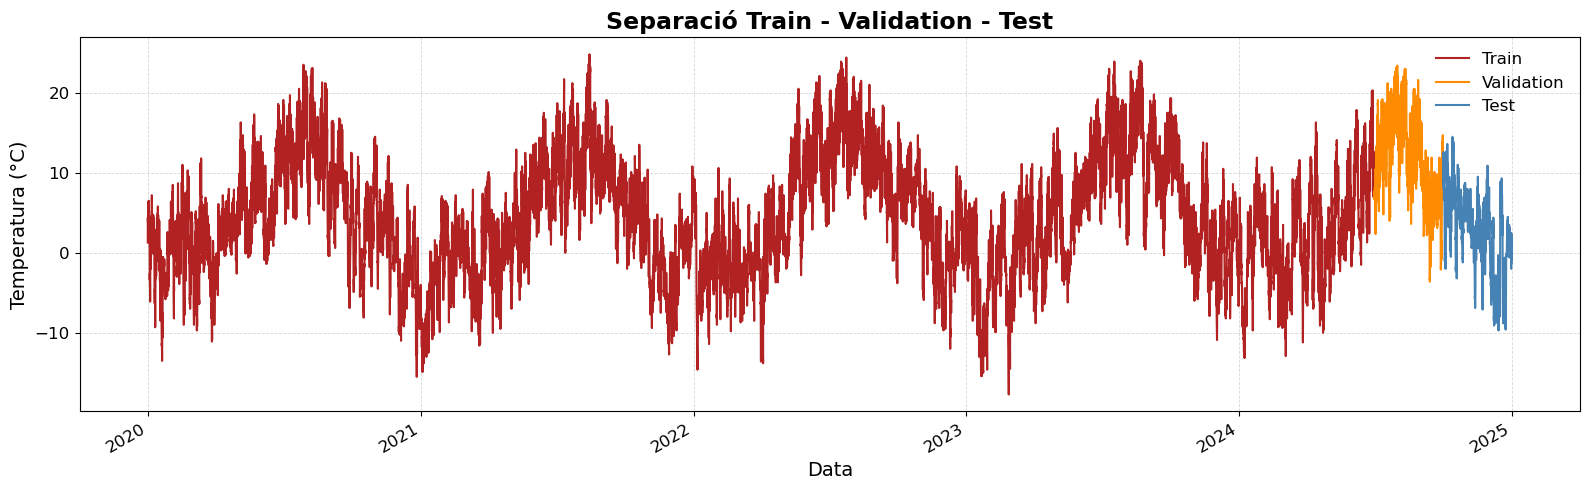

In [6]:

# Confirmem la separació amb un gràfic
plt.figure(figsize=(16, 5))
plt.plot(df_train['data'], df_train['valor'], label='Train', color='firebrick', linewidth=1.5)
plt.plot(df_val['data'], df_val['valor'], label='Validation', color='darkorange', linewidth=1.5)
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

plt.title('Separació Train - Validation - Test', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


# Definicó de Funcions

In [ ]:
# Funció per escalar les dades a milers

def escala_mil(x, pos):
    """
    Funció per formatar els ticks de l’eix Y multiplicant per 1000.
    És útil quan vols mostrar valors petits (com MSE en [0, 0.01]) en una escala més llegible.

    Args:
        x (float): valor del tick original (per exemple, 0.0013).
        pos (int): posició del tick en l’eix (0, 1, 2...). No s’utilitza aquí, però és necessari
                   perquè FuncFormatter sempre crida la funció amb dos arguments.

    Returns:
        str: valor formatat com a string, multiplicat per 1000 i amb 1 decimal (ex: '1.3').
    """
    val = x * 1000
    return f'{val:.1f}'



# Creem una funció per crear sequences per LSTM d'entrada

def create_sequences(series, window_size, n_outputs=1, n_slide=1):
    """
    Crea seqüències d'entrada i sortida per predicció simple o multi-output, 
    amb control del pas de desplaçament entre finestres.

    Args:
        series (array): sèrie temporal escalada.
        window_size (int): llargada de la finestra d'entrada.
        n_outputs (int): nombre de passos a predir (per defecte 1).
        n_slide (int): quant avancem la finestra a cada iteració (per defecte 1).

    LSTM espera una entrada en 3 dimensions:
    (n_samples, window_size, n_features)
        On:
    - n_samples = nombre de finestres que hem generat
    - window_size = longitud de cada finestra (número de valors consecutius)
    - n_features = nombre de variables per timestep (en aquest cas, 1 sola: la temperatura)

    Returns:
        X (np.array): seqüències d'entrada, forma (samples, window_size, 1).
        y (np.array): seqüències de sortida, forma (samples, n_outputs) si n_outputs > 1, 
                      o (samples, 1) si n_outputs = 1.
    """
    X, y = [], []
    i = window_size
    while i <= len(series) - n_outputs:
        X.append(series[i - window_size:i])
        if n_outputs == 1:
            y.append(series[i])
        else:
            y.append(series[i:i + n_outputs])
        i += n_slide
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y)
    if n_outputs == 1:
        y = y.reshape(-1, 1)  # Ara fa el reshape que Keras espera per a regressió 1D
    return X, y


 📊 Estratègies de predicció implementades


En aquest projecte s'han implementat tres estratègies de predicció basades en xarxes LSTM per tal d'avaluar diferents aproximacions a la predicció seqüencial de temperatura:

---

🟩 1. `prediccio_batch(...)` — Predicció directa per lots

Aquesta estratègia utilitza finestres fixes d'entrada (`X_test`) per fer prediccions independents de forma simultània. Cada finestra genera una predicció d’un únic pas i no depèn de les sortides anteriors.

**Ús típic:**
```python
df_test_pred, y_pred = prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='pred_batch')
```

---

🔁 2. `prediccio_multi_step_iterativa(...)` — Predicció iterativa encadenada

Predicció pas a pas: la sortida del model en cada pas es reinjecta com a entrada per predir el següent valor. Aquesta estratègia simula el funcionament d’un sistema en temps real, però pot acumular error amb el temps.

**Ús típic:**
```python
df_test_pred, y_pred_iter = prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter')
```

---

🔄 3. `prediccio_iterativa_reinjection(...)` — Predicció iterativa amb reinjecció de dades reals

Similars a l'estratègia iterativa, però cada `k` passos es reinjecta el valor real del conjunt de test. Això ajuda a estabilitzar les prediccions i reduir l’acumulació d’error.

**Ús típic:**
```python
df_test_pred, y_pred_reinject = prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject')
```

---

Totes les funcions modifiquen directament el `df_test_pred` afegint una columna amb les prediccions desescalades, i retornen també l’array de prediccions per facilitar l’anàlisi posterior (mètriques, gràfics, etc.).
```


In [236]:
def prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='pred_batch'):
    """
    Fa una predicció batch (totes les finestres alhora), desescala les prediccions i les afegeix directament a df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d’entrada per a la predicció (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor' desescalada. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions (per defecte 'pred_batch').

    Returns:
        df_test_pred (DataFrame): DataFrame amb la nova columna de predicció.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    # Predicció i desescalat
    y_pred = model.predict(X_test, verbose=0)
    y_pred_rescaled = scaler.inverse_transform(y_pred).flatten()

    # Assignar al DataFrame (ignorant les primeres files sense prou context)
    window_size = X_test.shape[1]
    idx_valid = df_test_pred.index[window_size:]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred




def prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter'):
    """
    Fa una predicció multi-step iterativa, reinjectant cada predicció com a nou input,
    i afegeix les prediccions desescalades directament a df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d’entrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor' desescalada. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions (per defecte 'pred_iter').

    Returns:
        df_test_pred (DataFrame): amb la nova columna de predicció iterativa afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    window_size = X_test.shape[1]
    n_passos = X_test.shape[0]

    seq = X_test[0].copy()  # Seqüència inicial escalada (window_size, 1)
    preds_scaled = []

    for _ in range(n_passos):
        input_seq = seq.reshape((1, window_size, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        preds_scaled.append(pred_scaled)
        seq = np.append(seq[1:], [[pred_scaled]], axis=0)

    # Desescalar les prediccions
    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # Assignar les prediccions desescalades al final del DataFrame
    idx_valid = df_test_pred.index[window_size:window_size + n_passos]
    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred

def prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject'):
    """
    Fa una predicció iterativa amb reinjecció de valors reals cada 'reinjeccio' passos,
    i afegeix les prediccions desescalades al df_test_pred.

    Args:
        model: model LSTM entrenat.
        X_test (np.array): finestres d’entrada (forma: (n_samples, window_size, 1)).
        df_test_pred (pd.DataFrame): DataFrame amb la columna 'valor_scaled'. Es modifica in-place.
        scaler: MinMaxScaler ajustat sobre les dades de train.
        reinjeccio (int): nombre de passos entre reinjeccions de dades reals.
        nom_columna (str): nom de la columna on s’enganxaran les prediccions.

    Returns:
        df_test_pred (DataFrame): amb la nova columna de prediccions afegida.
        y_pred_rescaled (np.array): prediccions desescalades (forma: (n_samples,)).
    """
    window_size = X_test.shape[1]
    n_passos = X_test.shape[0]

    seq = X_test[0].copy()  # Seqüència inicial (forma: (window_size, 1))
    preds_scaled = []
    valors_scaled = df_test_pred['valor_scaled'].values

    for i in range(n_passos):
        input_seq = seq.reshape((1, window_size, 1))
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        preds_scaled.append(pred_scaled)

        if (i + 1) % reinjeccio == 0:
            start_real = window_size + i + 1 - reinjeccio
            end_real = start_real + window_size
            if end_real <= len(valors_scaled):
                seq = valors_scaled[start_real:end_real].reshape(-1, 1).copy()
            else:
                seq = np.append(seq[1:], [[pred_scaled]], axis=0)
        else:
            seq = np.append(seq[1:], [[pred_scaled]], axis=0)

    y_pred_rescaled = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    # idx_valid = df_test_pred.index[window_size:window_size + n_passos]
    idx_valid = df_test_pred.iloc[window_size : window_size + n_passos].index

    df_test_pred.loc[idx_valid, nom_columna] = y_pred_rescaled

    return df_test_pred


# Preparació de les dades per a l'entrenament del model (escalació)

In [90]:
# Escalem la data

scaler = MinMaxScaler()

# Escalar només sobre train i transformar val i test
df_train['valor_scaled'] = scaler.fit_transform(df_train[['valor']])
df_val['valor_scaled'] = scaler.transform(df_val[['valor']])
df_test['valor_scaled'] = scaler.transform(df_test[['valor']])


# Observem com queden les dades
print('Train dataset shape:', df_train.shape)
display(df_train.head())

print('Validation dataset shape:', df_val.shape)
display(df_val.head())

print('Test dataset shape:', df_test.shape)
display(df_test.head())

Train dataset shape: (39432, 3)


,data,valor,valor_scaled
0,2020-01-01 00:00:00+00:00,1.30,0.45
1,2020-01-01 01:00:00+00:00,1.60,0.45
2,2020-01-01 02:00:00+00:00,3.20,0.49
3,2020-01-01 03:00:00+00:00,4.40,0.52
4,2020-01-01 04:00:00+00:00,4.00,0.51


Validation dataset shape: (2208, 3)


,data,valor,valor_scaled
0,2024-07-01 00:00:00+00:00,7.60,0.60
1,2024-07-01 01:00:00+00:00,6.80,0.58
2,2024-07-01 02:00:00+00:00,6.90,0.58
3,2024-07-01 03:00:00+00:00,6.90,0.58
4,2024-07-01 04:00:00+00:00,7.10,0.58


Test dataset shape: (2208, 3)


,data,valor,valor_scaled
0,2024-10-01 00:00:00+00:00,8.60,0.62
1,2024-10-01 01:00:00+00:00,9.70,0.64
2,2024-10-01 02:00:00+00:00,10.20,0.66
3,2024-10-01 03:00:00+00:00,10.50,0.66
4,2024-10-01 04:00:00+00:00,10.40,0.66


# Model LSTM step by step 1 predicció

## Preparació de les seqüències per a l'entrenament

In [217]:
# Parametres Globals del model LSTM

# Parametrització per a la creació de seqüències multi-step 
WINDOW_SIZE = 24  # provar més tard 48, 72, 168...
N_OUTPUTS = 1  # Per predicció simple, si fos multi-step seria > 1
N_SLIDE = 1  # Desplaçament de la finestra, 1 per predicció simple
N_FEATURES = 1  # Només una variable: temperatura

In [218]:
# Creem una copia del df_test per evitar canviar el df original i afegim les dades escalades i les posteriors prediccions
df_test_pred = df_test.copy()

# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)

In [219]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (39408, 24, 1)
y_train shape: (39408, 1)


## Deficinió del Model i entrenament


In [ ]:

# ============================
# Definim el model LSTM
# ============================

model = Sequential([
    # 1a capa LSTM amb 64 neurones (unitats)
    # - return_sequences=True perquè tenim més capes LSTM després
    # - input_shape = (timesteps, features) → cada seqüència té X valors de temperatura (1 feature)
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),

    # Dropout per reduir overfitting (desactiva aleatòriament un 20% de les neurones durant l'entrenament)
    Dropout(0.2),

    # 2a capa LSTM (encara retorna seqüències per passar-les a la següent LSTM)
    LSTM(64, return_sequences=True),
    Dropout(0.2),

    # 3a capa LSTM (última → no retorna seqüència, només la sortida final)
    LSTM(64),
    Dropout(0.2),

    # Capa de sortida Dense:
    # - 1 neurona perquè fem una predicció escalar (una sola temperatura)
    Dense(1)
])

# Compilació del model:
# - Optimitzador Adam → ajusta els pesos de forma eficient
# - Funció de pèrdua MSE → ideal per problemes de regressió com el nostre
model.compile(
    optimizer='adam',
    loss='mse'
)


# Callback EarlyStopping per aturar l'entrenament si no millora el val_loss
early_stop = EarlyStopping(
    monitor='val_loss',      # monitoritza la pèrdua de validació
    patience=5,              # espera 5 epochs sense millora abans d'aturar
    restore_best_weights=True  # recupera els pesos del millor epoch
)


In [ ]:
# Estableix la llavor per a la reproduïbilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Entrenament del model:
# - epochs = 50 → nombre d'iteracions sobre tot el dataset
# - batch_size = 32 → nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False → mantenim l'ordre de les dades per més control

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32, # mida del lot per l'entrenament
    validation_data=(X_val, y_val),  # validació amb dades de validació separades
    callbacks=[early_stop],
    verbose=1,
    shuffle=False  # opcional, si vols control total de l'ordre
)

In [ ]:
# Graficar l'evolució de la pèrdua durant l'entrenament

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(history.history['loss'], label='Pèrdua Entrenament')
ax.plot(history.history['val_loss'], label='Pèrdua Validació')
ax.set_title("Evolució de la pèrdua durant l'entrenament")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (×10⁻³)")

# Per ticks x cada 2 epochs
ax.set_xticks(np.arange(0, len(history.history['loss']), 1))

# Format ticks y amb 1 decimal
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))

# Força ticks a enters (però com fem decimals, pot ser opcional)
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))  # nbins controla nombre màxim ticks

ax.legend()
ax.grid(True)
plt.show()


In [18]:
# Creem el directori per guardar el model si no existeix
model_path = os.path.join(__path__, 'models', 'lstm_model.h5')
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Assegurem que el directori existeix


In [ ]:
# Guardem el model entrenat
# Guarda només l'arquitectura i els pesos, sense optimitzador ni funció de pèrdua
model.save(model_path, include_optimizer=False)

In [220]:
# Carrega del model guardat
model = load_model(model_path)
print("Model carregat correctament des de:", model_path)
print(model.summary())

Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/models/lstm_model.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model 

### Predicció batch

In [221]:
df_test_pred = prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='prediccio_batch')

In [222]:
# Avaluació de les mètriques

rmse_batch = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:]))
mse_batch = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:])
mae_batch = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_batch'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció batch: ")
print(f"   ▸ RMSE: {rmse_batch:.4f} °C")
print(f"   ▸ MSE: {mse_batch:.4f} °C²")
print(f"   ▸ MAE: {mae_batch:.4f} °C")

📊 Mètriques predicció batch: 
   ▸ RMSE: 0.8742 °C
   ▸ MSE: 0.7642 °C²
   ▸ MAE: 0.6152 °C


### Predicció Multi-Step Iterativa

In [ ]:
df_test_pred = prediccio_multi_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='prediccio_iter')

In [179]:
# Avaluació de les mètriques

rmse_iter = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:]))
mse_iter = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:])
mae_iter = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_iter'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció iterativa: ")
print(f"   ▸ RMSE: {rmse_iter:.4f} °C")
print(f"   ▸ MSE: {mse_iter:.4f} °C²")
print(f"   ▸ MAE: {mae_iter:.4f} °C")

📊 Mètriques predicció iterativa: 
   ▸ RMSE: 10.9260 °C
   ▸ MSE: 119.3783 °C²
   ▸ MAE: 9.7996 °C


### Predicció iterativa amb reinjecció de dades

In [237]:
df_test_pred = prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='prediccio_reinject')

In [238]:
# Avaluació de les mètriques

rmse_reinj = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:]))
mse_reinj = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:])
mae_reinj = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['prediccio_reinject'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció amb reinjecció: ")
print(f"   ▸ RMSE: {rmse_reinj:.4f} °C")
print(f"   ▸ MSE: {mse_reinj:.4f} °C²")
print(f"   ▸ MAE: {mae_reinj:.4f} °C")

📊 Mètriques predicció amb reinjecció: 
   ▸ RMSE: 3.5818 °C
   ▸ MSE: 12.8295 °C²
   ▸ MAE: 2.7137 °C


## Mètriques, errors i graficació 

In [226]:
# Taula comparativa de mètriques
mètriques = pd.DataFrame({
    'Mètrica': ['RMSE', 'MSE', 'MAE'],
    'Predicció Batch': [rmse_batch, mse_batch, mae_batch],
    'Predicció Iterativa': [rmse_iter, mse_iter, mae_iter],
    'Predicció Reinjecció': [rmse_reinj, mse_reinj, mae_reinj]
})
mètriques.set_index('Mètrica', inplace=True)
mètriques = mètriques.round(4)  # Arrodonim a 4 decimals
mètriques

,Predicció Batch,Predicció Iterativa,Predicció Reinjecció
Mètrica,,,
RMSE,0.87,10.93,3.58
MSE,0.76,119.38,12.83
MAE,0.62,9.80,2.71


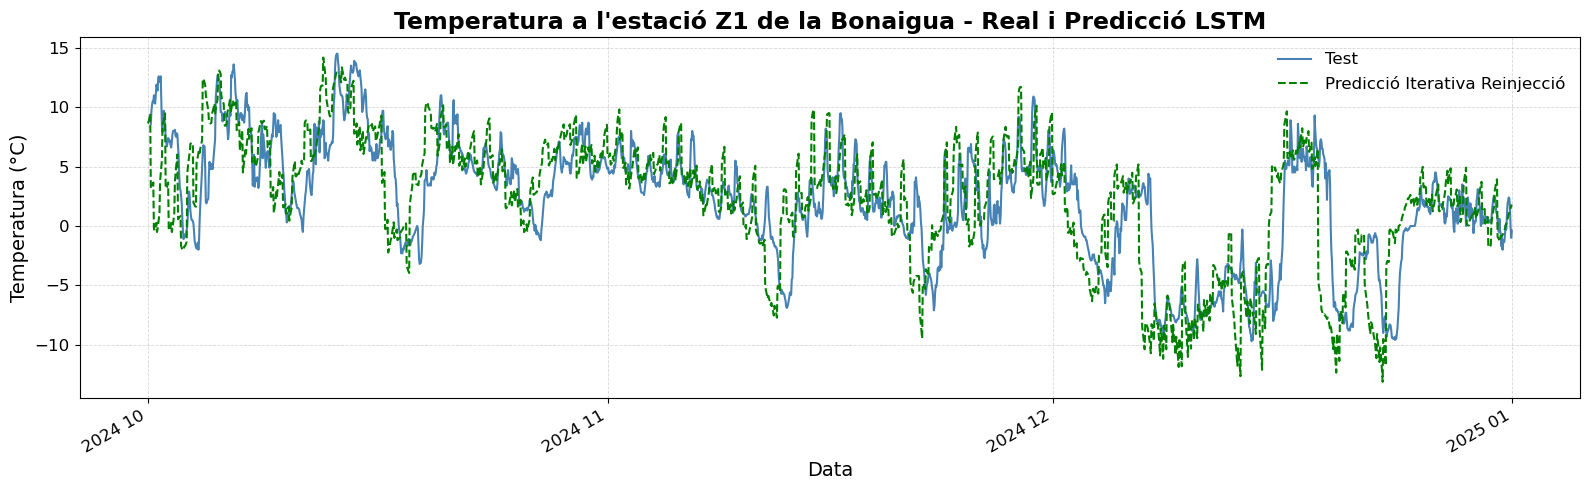

In [239]:
# Defineix quants dies enrere vols mostrar del train
dies_enrere = 30
data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
df_train_filtrat = df_train[df_train['data'] >= data_limit]

plt.figure(figsize=(16, 5))

# Últims dies del train
# plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label='Train (últims 30 dies)', color='firebrick', linewidth=1.5)

# Validació completa
# plt.plot(df_val['data'], df_val['valor'], label='Validation', color='darkgreen', linewidth=1.5)

# Test complet
plt.plot(df_test_pred['data'], df_test_pred['valor'].shift(5), label='Test', color='steelblue', linewidth=1.5)

# Predicció sobre test
# plt.plot(df_test_pred['data'], df_test_pred['prediccio_batch'], label='Predicció Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Predicció iterativa
# plt.plot(df_test_pred['data'], df_test_pred['prediccio_iter'], label='Predicció Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Predicció iterativa amb reinjecció
# plt.plot(df_test_pred['data'], df_test_pred['prediccio_reinject'], label='Predicció Iterativa Reinjecció', color='green', linewidth=1.5, linestyle='--')
plt.plot(df_test_pred['data'], df_test_pred['prediccio_reinject'], label='Predicció Iterativa Reinjecció', color='green', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estació Z1 de la Bonaigua - Real i Predicció LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


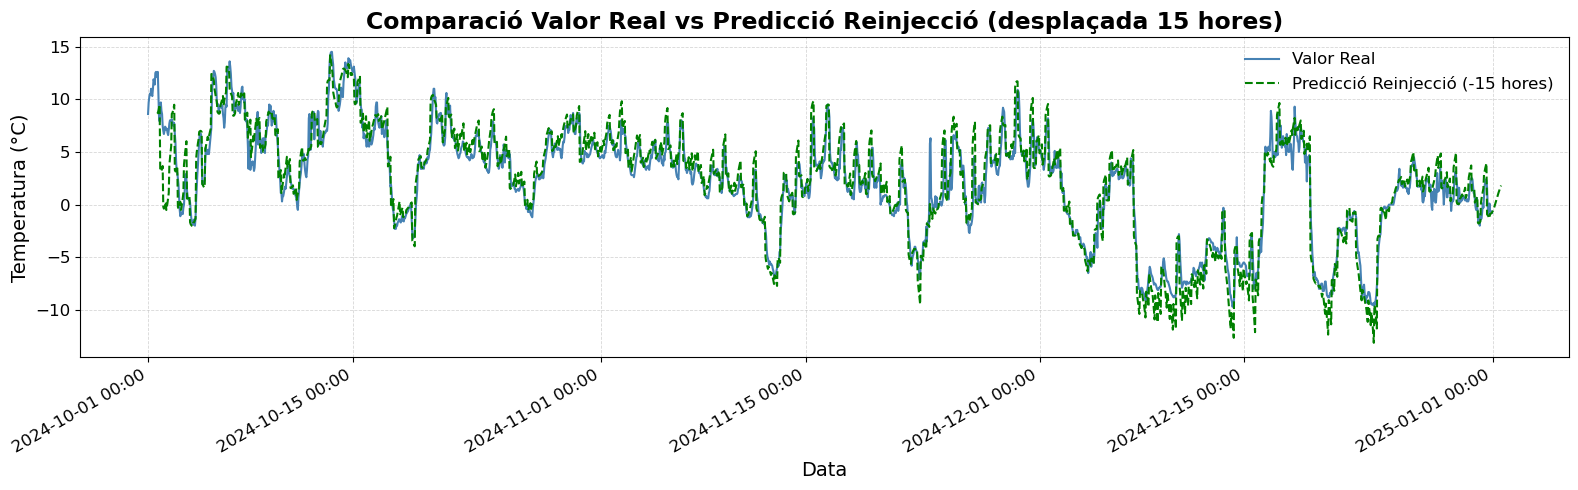

In [241]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Desplaçament en hores
desplaçament_hores = 15

# Crear dates desplaçades
dates_shifted = df_test_pred['data'] + pd.Timedelta(hours=desplaçament_hores)

# Valors
valors_reals = df_test_pred['valor']
valors_pred_reinject = df_test_pred['prediccio_reinject']

# Dibuix del gràfic
plt.figure(figsize=(16, 5))

# Sèrie real
plt.plot(df_test_pred['data'], valors_reals, label='Valor Real', color='steelblue', linewidth=1.5)

# Predicció desplaçada 5 hores enrere
plt.plot(dates_shifted, valors_pred_reinject, label='Predicció Reinjecció (-15 hores)', color='green', linestyle='--', linewidth=1.5)

# Format del gràfic
plt.title("Comparació Valor Real vs Predicció Reinjecció (desplaçada 15 hores)", fontsize=17, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Temperatura (°C)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

# Format eix temporal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [165]:
import plotly.graph_objects as go

fig = go.Figure()

# Train (últims 30 dies o tot)
fig.add_trace(go.Scatter(
    x=df_train['data'],
    y=df_train['valor'],
    mode='lines',
    name='Train',
    line=dict(color='firebrick', width=2)
))

# Validació
fig.add_trace(go.Scatter(
    x=df_val['data'],
    y=df_val['valor'],
    mode='lines',
    name='Validation',
    line=dict(color='darkgreen', width=2)
))

# Test
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['valor'],
    mode='lines',
    name='Test',
    line=dict(color='steelblue', width=2)
))

# Predicció sobre test
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['prediccio_batch'],
    mode='lines',
    name='Predicció batch',
    line=dict(color='darkorange', width=2, dash='dash')
))

# Predicció iterativa multi-step
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['prediccio_iter'],
    mode='lines',
    name='Predicció Iterativa',
    line=dict(color='purple', width=2, dash='dot')
))  

# Predicció iterativa amb reinjecció
fig.add_trace(go.Scatter(
    x=df_test_pred['data'],
    y=df_test_pred['prediccio_reinject'],
    mode='lines',
    name='Predicció Iterativa Reinjecció',
    line=dict(color='green', width=2, dash='dashdot')
))

fig.update_layout(
    title="Temperatura a l'estació Z1 de la Bonaigua - Real i Predicció LSTM",
    xaxis_title='Data',
    yaxis_title='Temperatura (°C)',
    legend=dict(font=dict(size=12)),
    hovermode='x unified',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()


KeyError: 'prediccio_batch'

In [67]:
# Calcular els errors de les diferents prediccions
df_test_pred['error_batch'] = df_test_pred['valor'] - df_test_pred['prediccio_batch']
df_test_pred['error_iter'] = df_test_pred['valor'] - df_test_pred['prediccio_iter']
df_test_pred['error_reinject'] = df_test_pred['valor'] - df_test_pred['prediccio_reinject']

df_test_pred.head() 


,data,valor,valor_scaled,prediccio_batch,prediccio_iter,prediccio_reinject,error_batch,error_iter,error_reinject
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN,NaN,NaN,NaN,NaN,NaN


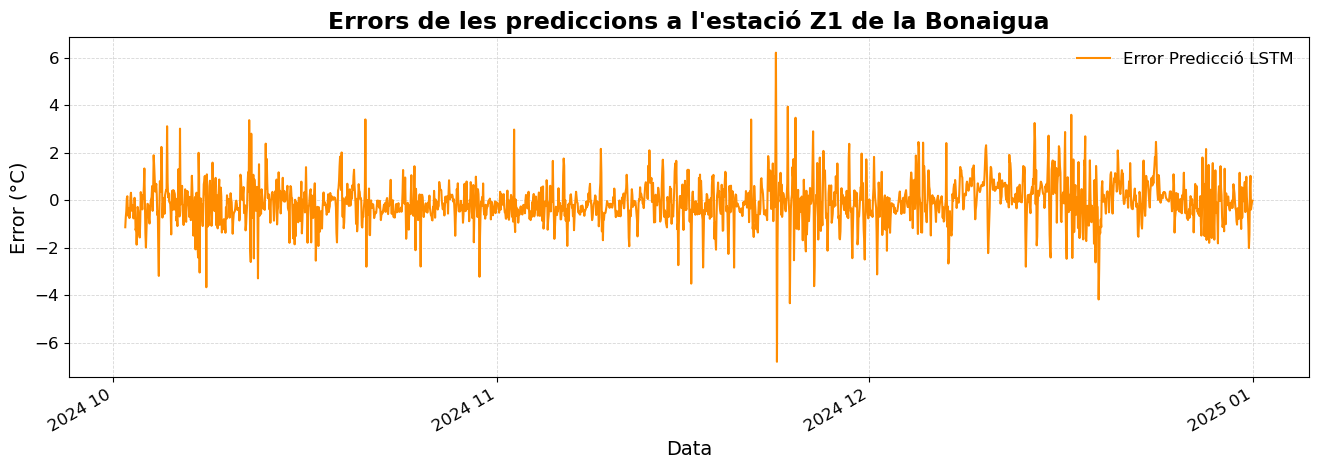

In [71]:
# Grafic dels errors de les prediccions
plt.figure(figsize=(16, 5))
plt.plot(df_test_pred['data'], df_test_pred['error_batch'], label='Error Predicció LSTM', color='darkorange', linewidth=1.5)        
plt.plot(df_test_pred['data'], df_test_pred['error_iter'], label='Error Predicció Iterativa', color='purple', linewidth=1.5)
plt.plot(df_test_pred['data'], df_test_pred['error_reinject'], label='Error Predicció Reinjecció', color='green', linewidth=1.5)

plt.title('Errors de les prediccions a l\'estació Z1 de la Bonaigua', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Error (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()   


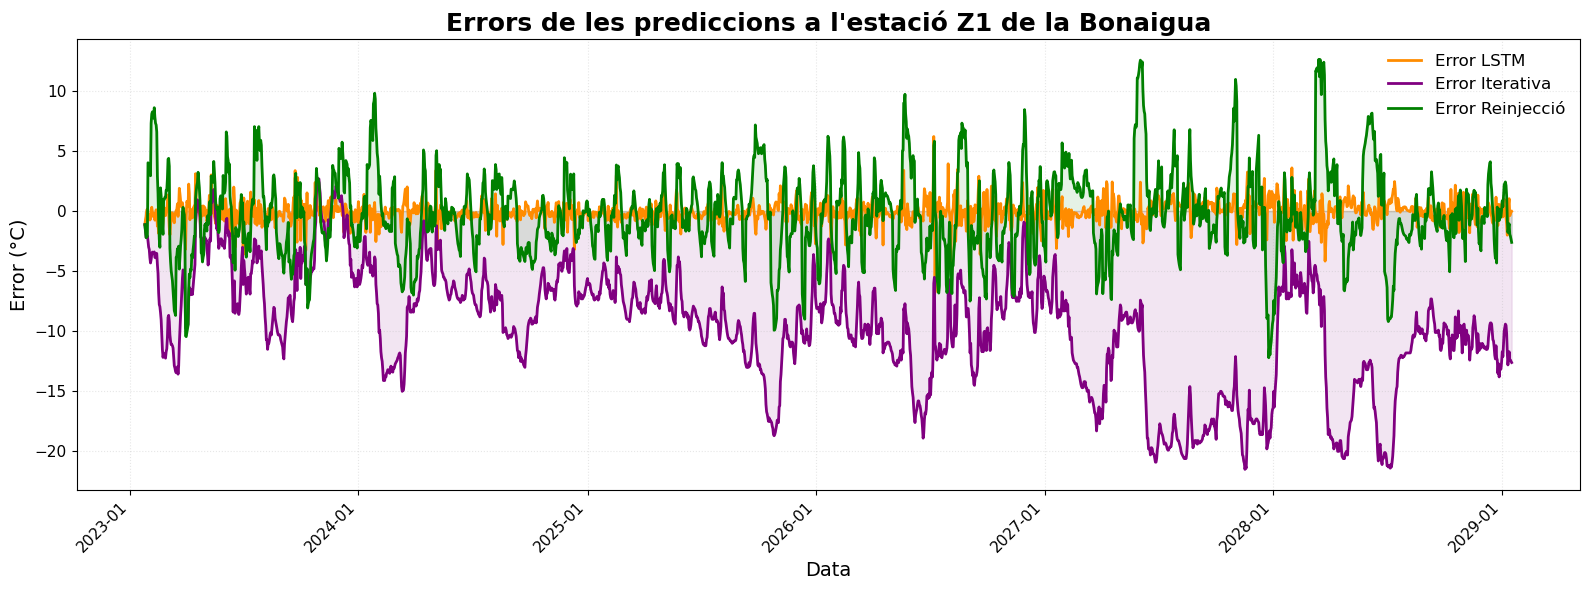

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ens assegurem que 'data' és de tipus datetime
df_test_pred['data'] = pd.to_datetime(df_test_pred['data'])

plt.figure(figsize=(16, 6))

# Plot de cada línia amb àrea sota
for col, color, label in zip(
    ['error_batch', 'error_iter', 'error_reinject'],
    ['darkorange', 'purple', 'green'],
    ['Error LSTM', 'Error Iterativa', 'Error Reinjecció']
):
    x = df_test_pred['data']
    y = df_test_pred[col].astype(float)
    plt.plot(x, y, label=label, color=color, linewidth=2)
    plt.fill_between(x, 0, y, color=color, alpha=0.1)

# Estètica del gràfic
plt.title("Errors de les prediccions a l'estació Z1 de la Bonaigua", fontsize=18, weight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Error (°C)", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(fontsize=12, frameon=False)

# Format de dates automàtic segons l'interval real del DataFrame
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


# Model Multioutput LSTM

## Preparació de les seqüències per a l'entrenament

In [111]:
# Parametres Globals del model LSTM

# Parametrització per a la creació de seqüències multi-step 
WINDOW_SIZE = 24  # provar més tard 48, 72, 168...
N_OUTPUTS = 5  # Nombre de passos de predicció futura (multi-step)
N_SLIDE = N_OUTPUTS  # Desplaçament de la finestra, 1 per predicció simple
N_FEATURES = 1  # Només una variable: temperatura

In [112]:
# Creem una copia de df_test per aquest model multi-step
df_test_pred_multi = df_test.copy()


# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred_multi['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)

In [129]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(7881, 24, 1) (7881, 5)
(436, 24, 1) (436, 5)
(436, 24, 1) (436, 5)


## Definició del Model Multioutput i entrenament

In [115]:
# ============================
# Definim el model LSTM multi-output
# ============================


model_multi = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(N_OUTPUTS)  # Capa final amb tantes neurones com outputs vulguem
])

model_multi.compile(
    optimizer='adam',
    loss='mse'
)

# Callback per early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [116]:
# Entrenament del model

# Reproductibilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Entrenament del model
history_multi = model_multi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)


print(model_multi.summary())

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0351 - val_loss: 0.0063
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0089 - val_loss: 0.0062
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 9/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 10/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 11/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 12/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 

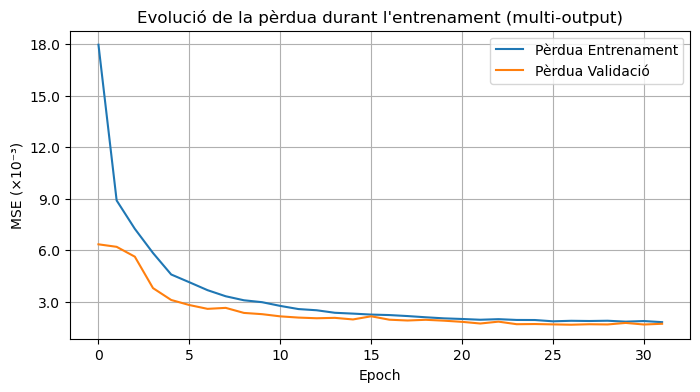

In [121]:
# ============================
# Gràfic de la pèrdua durant l'entrenament
# ============================

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history_multi.history['loss'], label='Pèrdua Entrenament')
ax.plot(history_multi.history['val_loss'], label='Pèrdua Validació')
ax.set_title("Evolució de la pèrdua durant l'entrenament (multi-output)")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (×10⁻³)")
ax.set_xticks(np.arange(0, len(history_multi.history['loss']), 5))
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))
ax.legend()
ax.grid(True)
plt.show()


In [122]:

# ============================
# Guardem i carreguem el model entrenat
# ============================

# Ruta per guardar el model multi-output
model_multi_path = os.path.join(__path__, 'models', 'lstm_model_multioutput.h5')
os.makedirs(os.path.dirname(model_multi_path), exist_ok=True)

# Guardem el model (sense optimitzador ni funció de pèrdua)
model_multi.save(model_multi_path, include_optimizer=False)


In [ ]:
# Carreguem el model
model_multi = load_model(model_multi_path)
print("Model carregat correctament des de:", model_multi_path)
print(model_multi.summary())


## Prediccions del model Multioutput

### Predicció batch multioutput

In [153]:
# Funció per fer prediccions multi-step

def prediccio_batch_multi(model, X_test, df_test, scaler, window_size, n_outputs, nom_columna='pred_batch_multi'):

    """
    Fa prediccions multi-output de manera contínua i enganxa totes les prediccions al DataFrame original.

    Supòsits:
    - S'utilitzen seqüències creades amb `n_slide = n_outputs`, per tant NO hi ha solapament entre finestres.
    - Cada finestra prediu exactament els següents `n_outputs` valors, i la següent finestra continua on acaba l’anterior.

    Args:
        model: Model LSTM multi-output entrenat.
        X_test (np.array): Matriu d’entrada per a test (n_samples, window_size, 1).
        df_test (pd.DataFrame): DataFrame original amb les dades reals, conté almenys la columna 'valor'.
        scaler: MinMaxScaler utilitzat per escalar i desescalar les dades.
        window_size (int): Mida de la finestra d’entrada per a cada seqüència.
        n_outputs (int): Nombre de passos que prediu el model (outputs per finestra).
        nom_columna (str): Nom de la columna on es guardaran les prediccions desescalades.

    Retorna:
        df_test amb la nova columna `nom_columna` que conté les prediccions (amb NaNs on no es pot predir).
    """
    # 1. Fer la predicció batch
    y_pred = model.predict(X_test, verbose=0)

    # 2. Desescalar les prediccions (per tornar a °C)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # 3. Inicialitzem la nova columna amb NaNs
    df_test[nom_columna] = np.nan

    # 4. Omplim la columna amb les prediccions multi-output (una fila per cada pas predit)
    for i in range(len(y_pred_rescaled)):
        for j in range(n_outputs):
            idx = window_size + i * n_outputs + j  # índex corresponent a la predicció j de la i-èsima seqüència
            if idx < len(df_test):
                df_test.at[idx, nom_columna] = y_pred_rescaled[i, j]

    return df_test



In [154]:
# Prova --> Resetejar el df_test_multi
df_test_pred_multi = df_test.copy()

df_test_pred_multi = prediccio_batch_multi(model_multi, X_test, df_test_pred_multi, scaler=scaler, window_size=WINDOW_SIZE, n_outputs=N_OUTPUTS, nom_columna='pred_batch_multi')

df_test_pred_multi

,data,valor,valor_scaled,pred_batch_multi
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN
...,...,...,...,...
2203,2024-12-31 19:00:00+00:00,0.10,0.42,2.55
2204,2024-12-31 20:00:00+00:00,-0.60,0.40,NaN
2205,2024-12-31 21:00:00+00:00,-0.60,0.40,NaN
2206,2024-12-31 22:00:00+00:00,-0.70,0.40,NaN


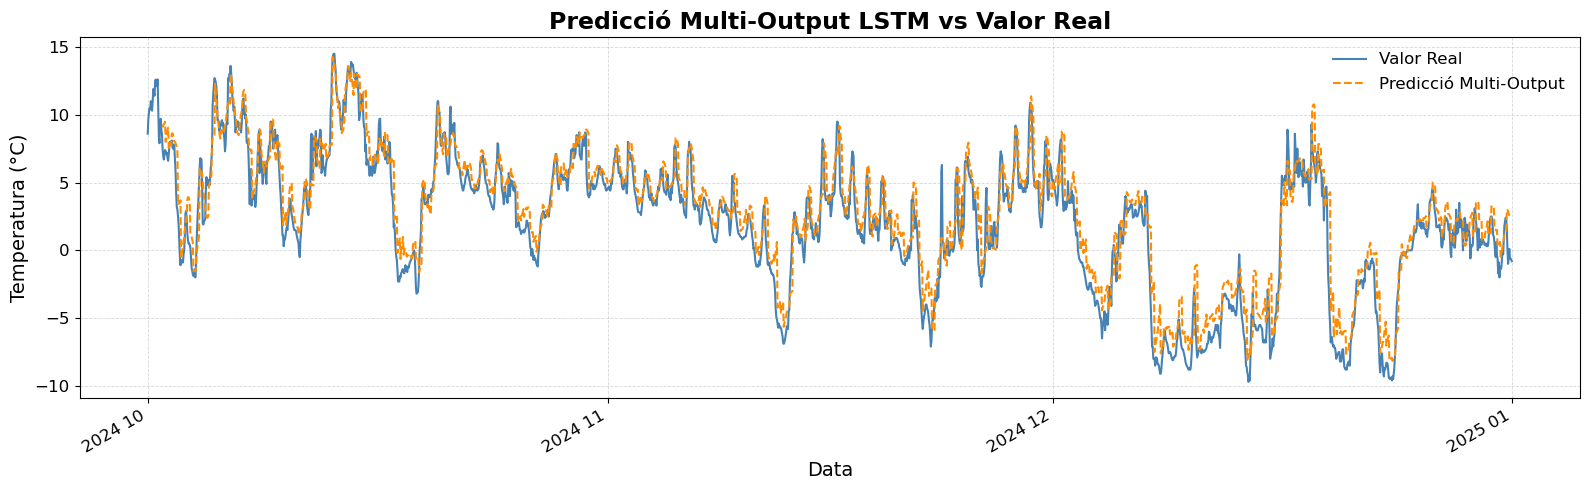

In [155]:
# Graficar les prediccions comparades amb les dades reals
plt.figure(figsize=(16, 5))
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['valor'], label='Valor Real', color='steelblue', linewidth=1.5)    
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_batch_multi'], label='Predicció Multi-Output', color='darkorange', linewidth=1.5, linestyle='--')
plt.title('Predicció Multi-Output LSTM vs Valor Real', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [157]:
df_test_pred_multi['valor'][WINDOW_SIZE:]

24      7.50
25      7.00
26      6.70
27      7.00
28      7.40
        ... 
2203    0.10
2204   -0.60
2205   -0.60
2206   -0.70
2207   -0.80
Name: valor, Length: 2184, dtype: float64

In [164]:
# Metriques de la predicció multi-output
rmse_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch_multi'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"📊 Mètriques predicció multi-output: ")
print(f"   ▸ RMSE: {rmse_multi:.4f} °C")
print(f"   ▸ MSE: {mse_multi:.4f} °C²")
print(f"   ▸ MAE: {mae_multi:.4f} °C")

📊 Mètriques predicció multi-output: 
   ▸ RMSE: 1.6835 °C
   ▸ MSE: 2.8342 °C²
   ▸ MAE: 1.2866 °C


### Predicció multi-step iterativa multioutput

### Predicció amb reinjecció de dades real multioutput

## Metriques, errors i graficació multioutput